In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# try to load a local style sheet for matplotlib
# see http://matplotlib.org/users/style_sheets.html
try:
    plt.style.use('presentation')
except:
    pass # do nothing if it cannot be found

# Der Fehler bei der Lagrangeschen Interpolation

*Andreas Potschka*

Gegeben sei eine $n+1$ mal stetig differenzierbare Funktion $f: [a, b] \to \mathbb{R}$ und paarweise verschiedene Stützstellen $x_0, \dotsc, x_n \in [a, b]$. Die Lagrangesche Interpolationsaufgabe lautet: Finde ein Polynom $n$-ten Grades $p \in P_n$, so dass

$$p(x_i) = f(x_i), \quad \text{für } i = 0, \dotsc, n.$$

Wir wissen, dass diese Aufgabe eindeutig lösbar ist und sich der Fehler an einer Stelle $x \in [a, b]$ für eine Zwischenstelle $\xi_x$ aus dem kleinsten Intervall, das alle $x_i$ und $x$ enthält, darstellen lässt in der Form

$$f(x) - p(x) = \frac{f^{(n+1)}(\xi_x)}{(n+1)!} \prod_{j=0}^n (x - x_j).$$

## Das Neville-Schema

Wie in der Vorlesung evaluieren das Interpolationspolynom $p$ im Neville-Schema. Aus Effizienzgründen darf `xi` hier gleich ein ganzer Vektor von Auswertungspunkten $\xi$ sein; die Stützpunkte sind durch die Stützstellen in `x` und die Werte in `y` festgelegt. Wir geben die Auswertung $p(\xi)$ als Vektor zurück.

In [15]:
def interpolate(xi, x, y):
    np1 = x.shape[0]
    p = np.empty((np1, np1))
    for j in range(np1):
        p[j,j] = y[j] * np.ones(xi.shape[0])
        for k in range(1, j + 1):
            i = j - k
            p[i,i+k] = p[i,i+k-1] + ((xi - x[i]) / (x[i+k] - x[i])
                                         * (p[i+1,i+k] - p[i,i+k-1]))
    
    print(p)
    return p[0,np1-1]

interpolate(np.array([61.7]), np.array([55.7, 57.7, 59.3, 62.6, 65.6]), np.array([1048, 1080, 1111, 1196, 1354]))

[[ 1048.          1144.          1166.5         1169.54751149
   1167.85680029]
 [    0.          1080.          1157.5         1170.00463822  1166.757838  ]
 [    0.             0.          1111.          1172.81818182
   1163.59220779]
 [    0.             0.             0.          1196.          1148.6       ]
 [    0.             0.             0.             0.          1354.        ]]


1167.8568002875338

## Plotten des Interpolationsfehlers

Die folgende Funktion nimmt als Argumente die Funktion $f$, die Intervallgrenzen $a$ und $b$ und einen Vektor von Stützstellen $x_i$. Sie wertet über das Neville-Schema das Interpolationspolynom $p$ zu $f$ und den Stützstellen auf einem feinen Gitter aus, das zudem die Stützstellen enthält. Die Funktionen $f$ und $p$ werden geplottet und der Fehler $|f(x)-p(x)|$ wird halblogarithmisch dargestellt (kleine Werte werden bei $10^{-16}$ abgeschnitten) und sein Maximum ausgegeben.

In [3]:
def plot_interpolant(f, a, b, x):
    xi = np.sort(np.concatenate((np.linspace(a, b, 1001), x)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
    f_xi = f(xi)
    ax1.plot(xi, f_xi)
    ax1.plot(x, f(x), 'kx')
    p_xi = interpolate(xi, x, f(x))
    ax1.plot(xi, p_xi)
    ax1.legend(('$f(x)$', '$f(x_i)$', '$p(x)$'))
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    err = abs(f_xi - p_xi)
    ax2.semilogy(xi, np.maximum(err, 1e-16), 'r')
    ax2.legend(('error $|f(x)-p(x)|$',))
    ax2.set_xlabel('$x$')
    print('Maximum error:', err.max())

## Beispiel 1

Wir betrachten die Funktion $f(x) = \sin(\pi x)$ auf dem Intervall $[-1, 1]$ mit äquidistanten Stützstellen.

Maximum error: 0.180758175512


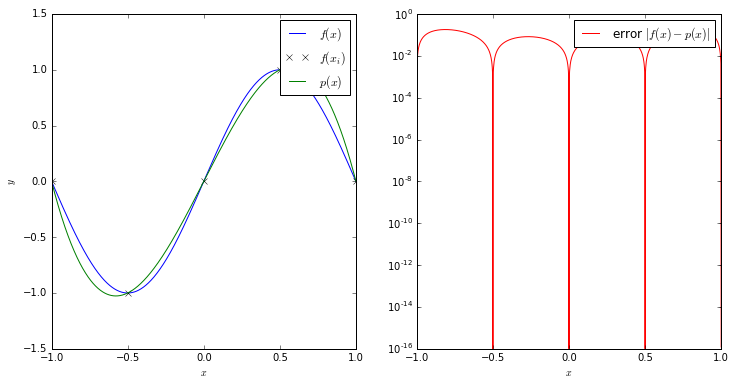

In [12]:
def f(x): return np.sin(np.pi * x)
a = -1.0
b = 1.0
x = np.linspace(a, b, 5
) # try: 3, 4, 5, 7, 11, 21
plot_interpolant(f, a, b, x)

Das scheint gut zu funktionieren, da $f^{(n+1)}$ nur wie $\pi^{n+1}$ wächst.

## Beispiel 2: Das Runge-Phänomen

Wir betrachten nun auf dem Intervall $[-1, 1]$ die Funktion

$$f(x) = \frac{1}{1 + 25 x^2}.$$ 

Maximum error: 0.432692307692


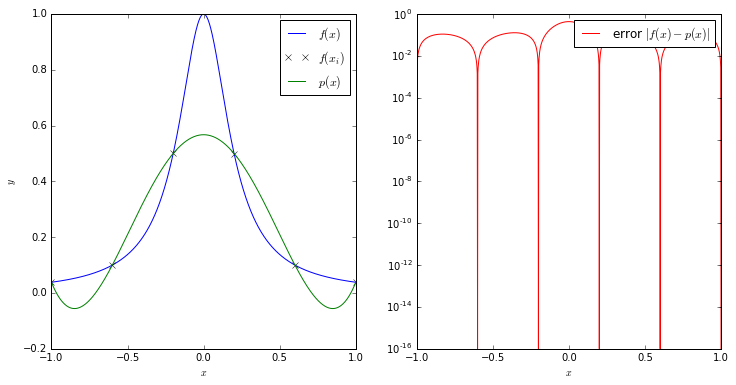

In [5]:
def f(x): return 1.0 / (1.0 + 25*x**2)
a = -1.0
b = 1.0
n = 5 # try 5, 6, 7, 11, 21
x = np.linspace(a, b, n + 1)
plot_interpolant(f, a, b, x)

Wir beobachten, dass an den Intervallenden große Oszillationen auftreten und der Interpolant $p$ nicht punktweise gegen $f$ konvergiert, wenn $n$ wächst. Das liegt daran, dass die Ableitungen von $f$ sehr stark anwachsen (Rannacher: $|f^{(n)}(x)| \approx 2^n n! O(|x|^{-2-n})$). 

Es stellt sich die Frage, ob man dieses Wachstum durch geschickte Wahl der Stützstellen im zweiten Term der Fehlerabschätzung $\prod_{j=0}^n (x - x_j)$ kompensieren kann.

## Stützstellen und Newton-Polynome

Für den zweiten Term der Fehlerabschätzung betrachten wir nun also das $(n+1)$-te Newton-Polynom

$$N_{n+1}(x) = \prod_{j=0}^n (x-x_j).$$

Für äquidistante Stützstellen beobachten wir folgendes:

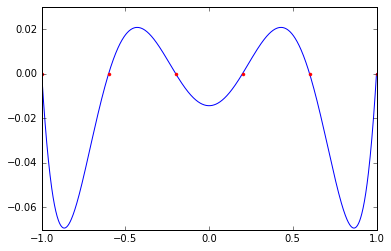

In [6]:
def N_np1(xi, x):
    p = np.ones_like(xi)
    for j in range(x.shape[0]):
        p *= (xi - x[j])
    return p

n = 5 # try 5, 6, 7, 11, 21
x = np.linspace(a, b, n + 1)
xi = np.linspace(a, b, 1001)
h = plt.plot(xi, N_np1(xi, x))
h = plt.plot(x, np.zeros_like(x), 'r.')

Offensichtlich weist das Polynom $N_{n+1}$ für äquidistante Stützstellen große Oszillationen an den Intervallenden auf.

Es ist daher sinnvoll, die Stützstellen so zu wählen, dass die Extrema von $N_{n+1}$ alle den gleichen Betrag haben. Dies leisten für $[a, b] = [-1, 1]$ die Tschebytschow-Punkte erster Art

$$x_i = \cos \left( \frac{2 i + 1}{2 (n + 1)} \pi \right), \quad i = 0, \dotsc, n.$$

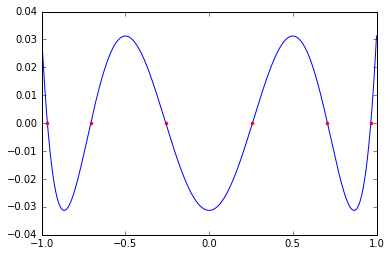

In [7]:
n = 5 # try 5, 6, 11, 21, 201
x = np.cos((2.0 * np.arange(0, n + 1) + 1) / (2.0 * (n + 1)) * np.pi)
xi = np.linspace(-1, 1, 1001)
h = plt.plot(xi, N_np1(xi, x))
h = plt.plot(x, np.zeros_like(x), 'r.')

Die Tschebytschow-Punkte erster Art sind die Nullstellen der Tschebytschow-Polynome erster Art, mit deren Hilfe man auch beweisen kann, dass

$$\max_{x \in [-1, 1]} |N_{n+1}(x)| \le 2^{-n}.$$

Mit dieser Wahl verbessert sich die Fehlerabschätzung immerhin zu

$$|f(x) - p(x)| \le \frac{f^{(n+1)}(\xi_x)}{2^n (n+1)!}.$$

## Das Beispiel von Runge mit Tschebytschow-Punkten

Mit dieser Wahl der Stützstellen ergibt sich ein anderes Bild:

Maximum error: 0.555911338812


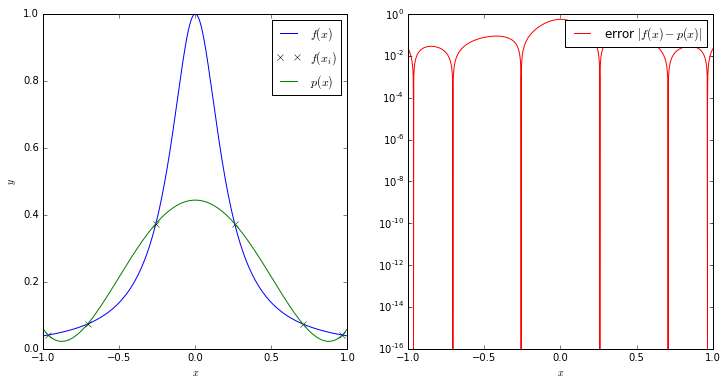

In [8]:
n = 5 # try 5, 6, 11, 21, 201
x = np.cos((2.0 * np.arange(0, n + 1) + 1) / (2.0 * (n + 1)) * np.pi)
plot_interpolant(f, -1, 1, x)

## Beispiel 3: Nicht-glatte Funktionen

Wir betrachten nun den Fall $f(x) = |x|$. Diese Funktion ist auf $[-1, 1]$ zwar stetig, aber nicht stetig differenzierbar. Die Fehlerabschätzung ist damit in diesem Fall nutzlos.

Maximum error: 0.172546030068


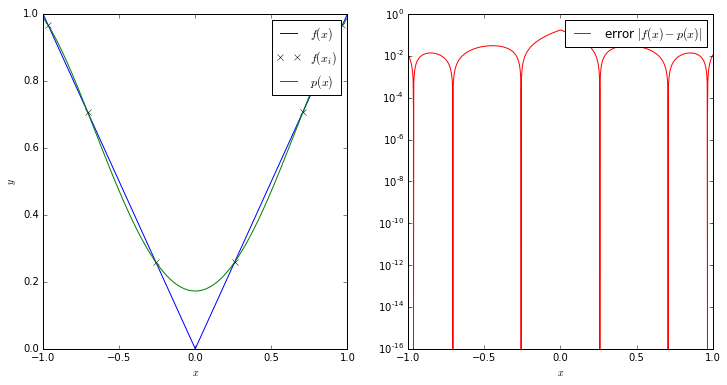

In [9]:
def f(x): return np.abs(x)

n = 5 # try 5, 6, 11, 21, 201
x = np.cos((2.0 * np.arange(0, n + 1) + 1) / (2.0 * (n + 1)) * np.pi)
plot_interpolant(f, -1, 1, x)

Offensichtlich ist auch in diesem pathologischen Fall das Verhalten überraschend gutartig. Bei äquidistanten Stützstellen ist man allerdings hoffnungslos verloren:

Maximum error: 0.108662727895


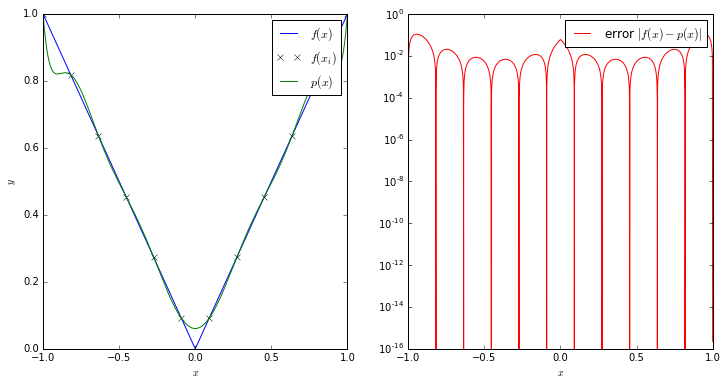

In [10]:
n = 11 # try 11, 21, 41
x = np.linspace(-1, 1, n+1)
plot_interpolant(f, -1, 1, x)

In der Tat kann man zeigen, dass jede Lipschitz-stetige Funktion durch Interpolation in den Tschebytschow-Punkten approximiert werden kann. Falls damit Ihr Interesse geweckt ist, seien als weiterführende Literatur der Artikel [Six Myths of Polynomial Interpolation and Quadrature (Trefethen)](https://people.maths.ox.ac.uk/trefethen/mythspaper.pdf) und die darin enthaltenen Referenzen empfohlen.